# Logitboost Assignment
Implement Logitboost using 1D linear regressors as weak learners. At each boosting
iteration choose the weak learner that obtains the largest reduction in the loss function
on the training set $D = \{(x_i, y_i), i = 1, ..., N\}, \text{ with } y_i \in  \{0, 1\}$:


#### Import dependencies

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from scipy.special import expit

#### Data loading functions

In [2]:
def get_gisette():
    path = "data/gisette/"   
    
    train_x = np.loadtxt(path+"gisette_train.data")
    train_y = np.loadtxt(path+"gisette_train.labels")
    
    valid_x = np.loadtxt(path+"gisette_valid.data")
    valid_y = np.loadtxt(path+"gisette_valid.labels")
    
    return train_x, train_y, valid_x, valid_y



def get_dexter():
    path = "data/dexter/"

    train_x = np.loadtxt(path+"dexter_train.csv", delimiter=',')
    train_y = np.loadtxt(path+"dexter_train.labels")

    valid_x = np.loadtxt(path+"dexter_valid.csv", delimiter=',')
    valid_y = np.loadtxt(path+"dexter_valid.labels")

    return train_x, train_y, valid_x, valid_y

def get_madelon():
    path = "data/MADELON/"

    train_x = np.loadtxt(path + "madelon_train.data")
    train_y = np.loadtxt(path + "madelon_train.labels")
    test_x = np.loadtxt(path + "madelon_valid.data")
    test_y = np.loadtxt(path + "madelon_valid.labels")

    return train_x, train_y, test_x, test_y

#### Normalization function

In [3]:
def normalize(train, *args):
    mean = np.average(train, axis=0)
    standard_deviation = np.std(train, axis=0)
    columns = train, *args
    return tuple(np.divide(column-mean, standard_deviation, where=standard_deviation!=0)
                 for column in columns)


#### Analytically find optimal linear regresson for each feature in x with obervations weights z

In [4]:
def linear_regressor_for_each_feature(x, y, w):
    mean_x = w @ x / np.sum(w)
    mean_y = np.sum(w*y) / np.sum(w)
    denominators = w @ np.square(x-mean_x)
    beta_1= np.divide((w*(y-mean_y))@(x-mean_x), denominators, where=~np.isclose(denominators,0))
    beta_0 = mean_y + beta_1 * mean_x
    return beta_0, beta_1

#### Find feature who's beta has the highest reduction in loss

In [5]:
def beta_selection(x, beta0, beta1, y, h):

    h_prediction = np.sum(x * h[:,1] + h[:,0], axis=1)
    new_beta1s = np.diag(beta1) # create diagonal p x p matrix
    beta_predictions = np.dot(x,new_beta1s) + beta0
    final_prediction = beta_predictions+h_prediction[np.newaxis].T
    ytilde=2*y-1
    final_prediction = np.clip(final_prediction, -100, 100)
    loss=np.sum(np.log(1+np.exp(-ytilde*final_prediction.T)), axis=1)

    beta_index = np.argmin(loss)
    beta_filter = np.zeros_like(beta0) # array of ones of same length as beta0
    beta_filter[beta_index] = 1 # set the spot at beta_index to 0
    beta0[beta_filter==0] = 0 # all indices at which filter==1 are set to 0, to beta 0 has zeroes everywhere except beta_index
    beta1[beta_filter==0] = 0
    return np.column_stack(np.dstack((beta0,beta1)))

#### Make prediction using the linear boosted model

def predict(x, b1, b0):
    prediction = np.sum(x*b1 + b0, axis=1)
    prediction[prediction >= 0] = 1
    prediction[prediction < 0] = 0
    return prediction

In [6]:
def predict(x, b1, b0):
    prediction = np.sum(x*b1 + b0, axis=1)
    prediction[prediction >= 0] = 1
    prediction[prediction < 0] = 0
    return prediction

#### Train Logitboost

In [7]:
def train_logit(train_x, train_y, test_x, test_y, iterations):
    train_x, test_x = normalize(train_x, test_x)
    train_y[train_y==-1] = 0
    test_y[test_y==-1] = 0
    trainscore=[]
    testscore=[]
    h = np.zeros([train_x.shape[1],2])

    np.seterr("raise")
    for _ in range(iterations):
        h_x= np.sum(train_x * h[:,1] + h[:,0], axis=1)
        p=expit(h_x)
        p[p==1]=.999
        p[p==0]=.001
        w_i=(p)*(1-p)
        denominator = (p*(1-p))
        z = np.divide((train_y - p),denominator)
        Beta0, Beta1 = linear_regressor_for_each_feature(train_x, z, w_i)
        selected_betas= beta_selection(train_x, Beta0, Beta1, train_y, h)
        h += selected_betas
        trainscore.append(1-accuracy_score(train_y, predict(train_x, h[:,1], h[:,0])))
        testscore.append(1-accuracy_score(test_y, predict(test_x, h[:,1], h[:,0])))

    return trainscore, testscore

#### Plot the error vs iteration and display final error in a table

In [8]:
def plot(train_errors, test_errors, iteration, train_error_to_plot, test_error_to_plot):
    i = list(range(len(test_error_to_plot)))
    plt.plot(i, train_error_to_plot)
    plt.plot(i, test_error_to_plot)
    plt.legend(["Train", "Test"])
    plt.xlabel("Iterations")
    plt.ylabel("Misclassification error")
    plt.title("Error vs iterations with 500 features")

    print(test_errors)
    test_errors = [f"{test_error:.3f}" for test_error in test_errors]
    train_errors = [f"{train_error:.3f}" for train_error in train_errors]
    plt.table(cellText=[*zip(iteration, train_errors, test_errors)], colLabels=['Iteration', 'Training error', 'Test error'],
              bbox=[0.0,-0.8, 1,.4], edges="closed" )
    plt.show()

#### Train and plot Logitboost

In [9]:
def plot_logit(xtrain, ytrain, xtest, ytest):

    iterations=[10, 30, 100, 300, 500]

    trainscore, testscore = train_logit(xtrain, ytrain, xtest, ytest, iterations[-1])

    error_train = [trainscore[n-1] for n in iterations]
    error_test = [testscore[n-1] for n in iterations]
    plot(error_train, error_test, iterations, trainscore, testscore)

## a) Gisette

Using the Gisette data, train a Logitboost classifier on the training set, with k $\in$ {10, 30, 100, 300, 500} boosted iterations. Plot the training loss vs iteration number for k = 500. Report in a table the misclassification errors on the training and test set for the models obtained for all these k. Plot the misclassification errors on the training and test set vs k. (5 points)

In [10]:
train_x, train_y, test_x, test_y = get_gisette()

In [ ]:
plot_logit(train_x, train_y, test_x, test_y)

## b) Dexter
Repeat point a) on the dexter dataset

In [ ]:
train_x, train_y, test_x, test_y = get_dexter()

In [ ]:
plot_logit(train_x, train_y, test_x, test_y)

## c) Madelon
Repeat point a) on the madelon dataset

[0.07799999999999996, 0.04500000000000004, 0.028000000000000025, 0.02300000000000002, 0.02100000000000002]


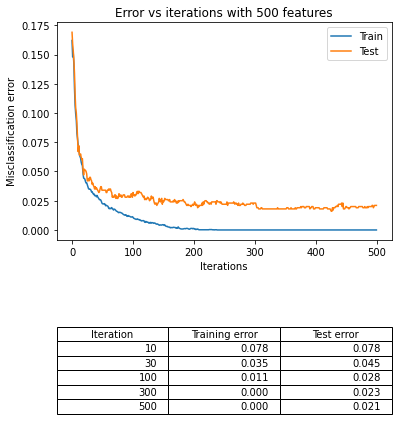

In [11]:
train_x, train_y, test_x, test_y = get_madelon()

## b) Dexter
Repeat point a) on the dexter dataset

In [12]:
train_x, train_y, test_x, test_y = get_dexter()

[0.10333333333333339, 0.14, 0.1266666666666667, 0.09666666666666668, 0.1433333333333333]


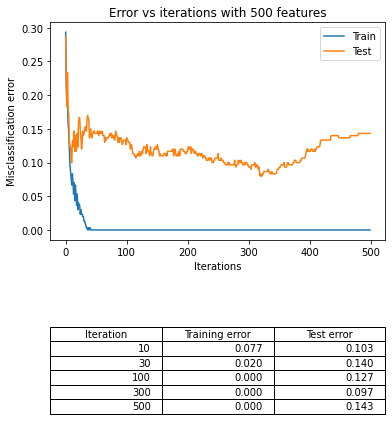

In [13]:
plot_logit(train_x, train_y, test_x, test_y)

## c) Madelon
Repeat point a) on the madelon dataset

In [14]:
train_x, train_y, test_x, test_y = get_madelon()

[0.4033333333333333, 0.42833333333333334, 0.43333333333333335, 0.43166666666666664, 0.41833333333333333]


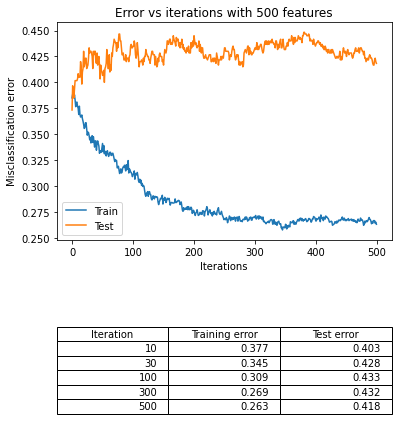

In [15]:
plot_logit(train_x, train_y, test_x, test_y)
